#### Writing and Reading Time Series with TimeDB SDK

This notebook demonstrates:
1. Writing time series data without specifying series_id (auto-generated)
2. Reading data back and plotting with series_id in legend
3. Writing multiple time series with the same series_id (updates)
4. Reading back to see consolidated time series


In [15]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta


## Part 1: Two Different Time Series (Different Series IDs)

First, let's create the schema and write two different time series without specifying series_id.


In [16]:
# Delete database schema
td.delete()

In [17]:
# Create database schema
td.create()

Creating database schema...
✓ Schema created successfully


In [ ]:
# Create first time series: Temperature data (first 24 hours: 0-23)
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
dates1 = [base_time + timedelta(hours=i) for i in range(24)]
df1 = pd.DataFrame({
    'valid_time': dates1,
    'value': [20.0 + i * 0.3 for i in range(24)]  # Temperature rising
})

# Insert first time series (series_id will be auto-generated)
result1 = td.insert_run(df=df1)
print(f"✓ Inserted first time series with series_id: {result1.series_ids}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")


Data values inserted successfully.
✓ Inserted first time series with series_id: {'value': UUID('b9b78f5c-163c-4fa2-b746-a56443a152cd')}
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00


In [19]:
# Create second time series: Humidity data (next 24 hours: 24-47, following the first)
dates2 = [base_time + timedelta(hours=i) for i in range(24, 48)]  # Hours 24-47
df2 = pd.DataFrame({
    'valid_time': dates2,
    'value': [30.0 - (i-24) * 0.5 for i in range(24, 48)]  # Humidity decreasing
})

# Insert second time series (series_id will be auto-generated, different from first)
result2 = td.insert_run(df=df2)
print(f"✓ Inserted second time series with series_id: {result2.series_ids}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")


Data values inserted successfully.
✓ Inserted second time series with series_id: {'value': UUID('1229de4d-cd63-4cfc-a75c-0d820bd9117b')}
  Time range: 2025-01-02 00:00:00+00:00 to 2025-01-02 23:00:00+00:00


In [20]:
# Read back all time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nSeries IDs in data: {df_read.columns}")
print(f"\nFirst few rows:")
print(df_read.head(10))


✓ Read 48 rows

DataFrame shape: (48, 2)

Series IDs in data: Index(['value', 'value'], dtype='object', name='series_key')

First few rows:
series_key                 value  value
valid_time                             
2025-01-01 00:00:00+00:00    nan   20.0
2025-01-01 01:00:00+00:00    nan   20.3
2025-01-01 02:00:00+00:00    nan   20.6
2025-01-01 03:00:00+00:00    nan   20.9
2025-01-01 04:00:00+00:00    nan   21.2
2025-01-01 05:00:00+00:00    nan   21.5
2025-01-01 06:00:00+00:00    nan   21.8
2025-01-01 07:00:00+00:00    nan   22.1
2025-01-01 08:00:00+00:00    nan   22.4
2025-01-01 09:00:00+00:00    nan   22.7


Index(['value', 'value'], dtype='object', name='series_key')
HI
HI


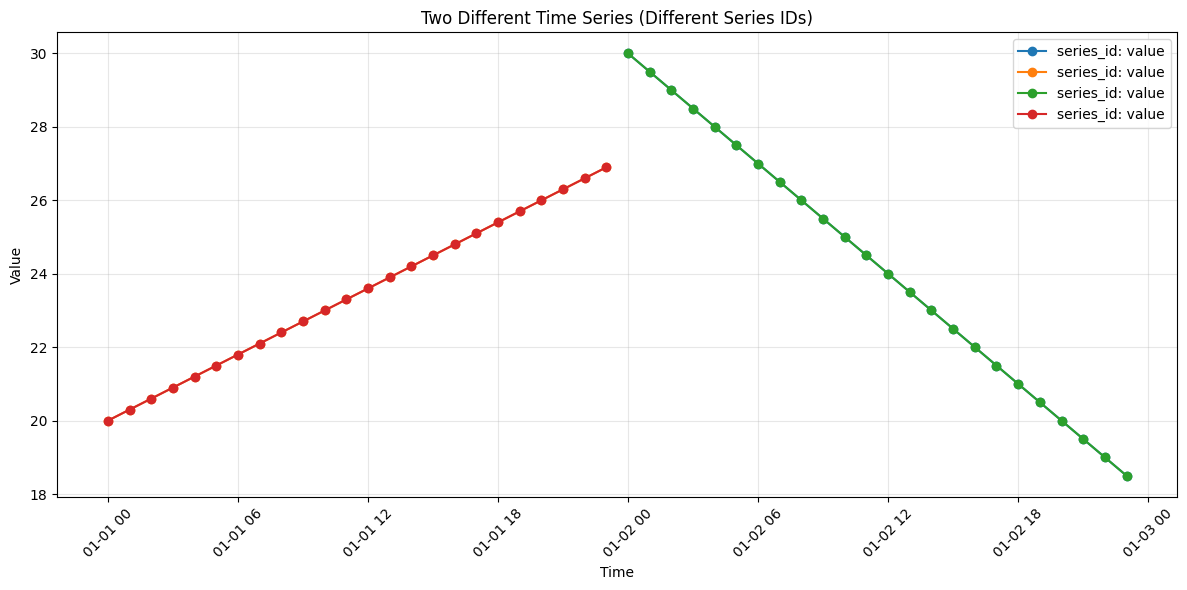


✓ Plotted 2 different time series (different series_ids)


In [ ]:
# Plot the time series (data is already in the right format)
plt.figure(figsize=(12, 6))
for series_id in df_read.columns:
    plt.plot(df_read.index, df_read[series_id], marker='o', label=f'series_id: {series_id}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Two Different Time Series (Different Series IDs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_read.columns)} different time series (different series_ids)")


## Part 2: Same Series ID (Consolidated Time Series)

Now let's delete the schema and repeat, but this time we'll use the same series_id for both writes.


In [9]:
# Delete schema to start fresh
td.delete()

# Create schema again
td.create()

Creating database schema...
✓ Schema created successfully


In [10]:
# Create a shared series_id
import uuid
shared_series_id = uuid.uuid4()
print(f"Using shared series_id: {shared_series_id}")


Using shared series_id: 72e065e6-e9fa-40fd-9934-ffe1d0582f1e


In [11]:
# Insert first time series with explicit series_id
result1 = td.insert_run(df=df1, series_ids={'value': shared_series_id})
print(f"✓ Inserted first time series with series_id: {result1.series_ids}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")

Data values inserted successfully.
✓ Inserted first time series with series_id: {'value': UUID('72e065e6-e9fa-40fd-9934-ffe1d0582f1e')}
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00


In [12]:

# Insert second time series with the SAME series_id
result2 = td.insert_run(df=df2, series_ids={'value': shared_series_id})
print(f"✓ Inserted second time series with series_id: {result2.series_ids}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")
print(f"  (Same series_id as first: {result1.series_ids == result2.series_ids})")
print(f"  Note: The two time series will be stitched together since they have consecutive time ranges!")


Data values inserted successfully.
✓ Inserted second time series with series_id: {'value': UUID('72e065e6-e9fa-40fd-9934-ffe1d0582f1e')}
  Time range: 2025-01-02 00:00:00+00:00 to 2025-01-02 23:00:00+00:00
  (Same series_id as first: True)
  Note: The two time series will be stitched together since they have consecutive time ranges!


In [13]:
# Read back all time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nSeries IDs in data: {df_read.columns}")
print(f"\nFirst few rows:")
print(df_read.head(10))


✓ Read 48 rows

DataFrame shape: (48, 1)

Series IDs in data: Index(['value'], dtype='object', name='series_key')

First few rows:
series_key                 value
valid_time                      
2025-01-01 00:00:00+00:00   20.0
2025-01-01 01:00:00+00:00   20.3
2025-01-01 02:00:00+00:00   20.6
2025-01-01 03:00:00+00:00   20.9
2025-01-01 04:00:00+00:00   21.2
2025-01-01 05:00:00+00:00   21.5
2025-01-01 06:00:00+00:00   21.8
2025-01-01 07:00:00+00:00   22.1
2025-01-01 08:00:00+00:00   22.4
2025-01-01 09:00:00+00:00   22.7


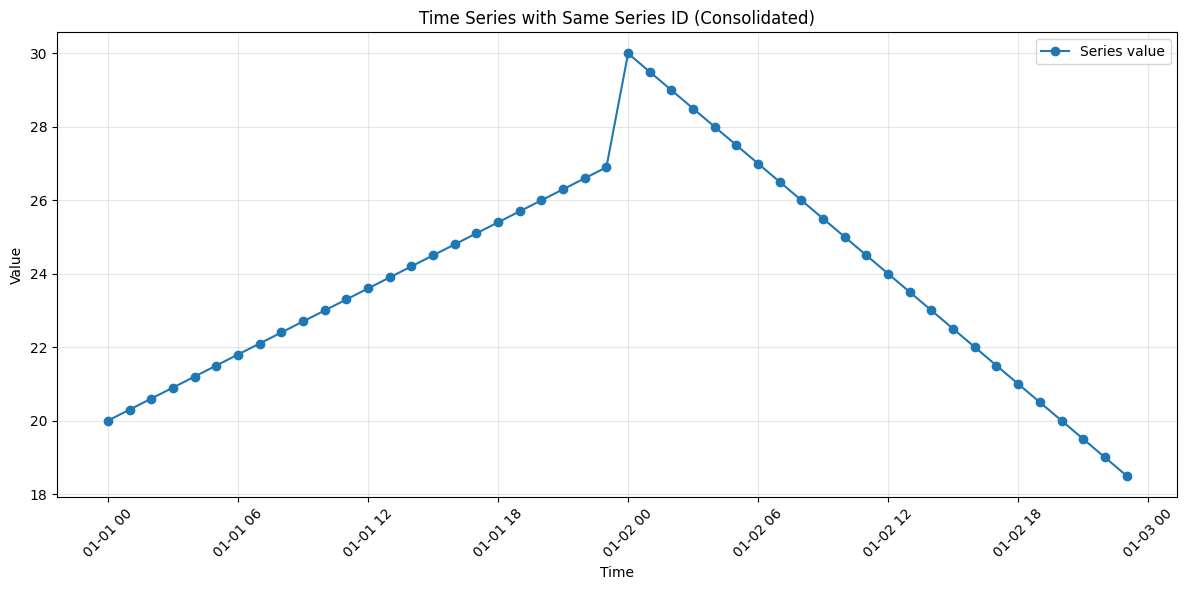


✓ Plotted 1 time series
  Note: Both writes used the same series_id, so we see one consolidated time series


In [14]:
# Plot the time series (data is already in the right format)
plt.figure(figsize=(12, 6))
for series_id in df_read.columns:
    plt.plot(df_read.index, df_read[series_id], marker='o', label=f'Series {series_id}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Same Series ID (Consolidated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_read.columns)} time series")
print(f"  Note: Both writes used the same series_id, so we see one consolidated time series")
